Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

## Do train/validate/test split with the Tanzania Waterpumps data

In [0]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

## Define a function to wrangle train, validate, and test sets in the same way. 

Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)

In [0]:
# Count zeros per column
(train == 0).sum().sort_values(ascending=False)

num_private              46932
amount_tsh               33265
population               17066
construction_year        16517
gps_height               16305
permit                   14006
public_meeting            4038
longitude                 1442
district_code               19
id                           1
region_code                  0
ward                         0
lga                          0
date_recorded                0
region                       0
funder                       0
basin                        0
wpt_name                     0
latitude                     0
installer                    0
subvillage                   0
status_group                 0
recorded_by                  0
water_quality                0
waterpoint_type              0
source_class                 0
source_type                  0
source                       0
quantity_group               0
quantity                     0
quality_group                0
payment_type                 0
waterpoi

In [0]:
# Construction year is zero, over 25% of the time
# Does that mean those waterpumps were constructed in 0 AD?
# Probably not.
# We'll add it to the cols_with_zeros list in the wrangle function.
train['construction_year'].describe()

count    47520.000000
mean      1302.768939
std        950.955437
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [0]:
# GPS height is frequently zero also.
# This is harder to decide what to do, 
# because zero is a plausible value (sea level).
# But it seems suspicious to be exactly 0 so often.
# It may or may not make a difference in the model.
# But we'll add gps_height to the cols_with_zero list in the wrangle function.
train['gps_height'].describe()

count    47520.000000
mean       669.567656
std        693.005745
min        -63.000000
25%          0.000000
50%        372.500000
75%       1320.000000
max       2770.000000
Name: gps_height, dtype: float64

In [0]:
# Same with population. 
# Zero is a possible value.
# But we'll add population to the cols_with_zero list in the wrangle function.
train['population'].describe()

count    47520.000000
mean       179.805513
std        463.081564
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      15300.000000
Name: population, dtype: float64

In [0]:
# Look for more duplicate / near duplicate columns, besides quanity_group & quantity.
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,47520,1,GeoData Consultants Ltd,47520
public_meeting,44876,2,True,40838
permit,45077,2,True,31071
status_group,47520,3,functional,25807
source_class,47520,3,groundwater,36638
quantity_group,47520,5,enough,26567
quantity,47520,5,enough,26567
management_group,47520,5,user-group,42027
quality_group,47520,6,good,40598
waterpoint_type_group,47520,6,communal standpipe,27642


More possibilities to consider, because of similar names & cardinality:

- extraction_type, extraction_type_class, extraction_type_group
- management, scheme_management
- payment, payment_type
- quality_group, water_quality
- waterpoint_type, waterpoint_type_group

In [0]:
# extraction_type has the most detail
train[['extraction_type', 'extraction_type_class', 'extraction_type_group']].describe()

,extraction_type,extraction_type_class,extraction_type_group
count,47520,47520,47520
unique,18,7,13
top,gravity,gravity,gravity
freq,21448,21448,21448


In [0]:
# management has no missing values
train[['management', 'scheme_management']].describe()

,management,scheme_management
count,47520,44392
unique,12,12
top,vwc,VWC
freq,32449,29470


In [0]:
# Looks like these are exact duplicates ...
train[['payment', 'payment_type']].describe()

,payment,payment_type
count,47520,47520
unique,7,7
top,never pay,never pay
freq,20287,20287


In [0]:
train['payment'].value_counts()

never pay                20287
pay per bucket            7161
pay monthly               6644
unknown                   6532
pay when scheme fails     3093
pay annually              2938
other                      865
Name: payment, dtype: int64

In [0]:
train['payment_type'].value_counts()

never pay     20287
per bucket     7161
monthly        6644
unknown        6532
on failure     3093
annually       2938
other           865
Name: payment_type, dtype: int64

In [0]:
# water_quality has more detail
train[['quality_group', 'water_quality']].describe()

,quality_group,water_quality
count,47520,47520
unique,6,8
top,good,soft
freq,40598,40598


In [0]:
# waterpoint_type has more detail
train[['waterpoint_type', 'waterpoint_type_group']].describe()

,waterpoint_type,waterpoint_type_group
count,47520,47520
unique,7,6
top,communal standpipe,communal standpipe
freq,22778,27642


In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'extraction_type_class', 
                  'extraction_type_group', 'scheme_management', 
                  'payment_type', 'quality_group', 'waterpoint_type_group']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
   
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

## Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=target)

# Get a list of the numeric features
numeric_features = train.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'year_recorded', 'month_recorded', 'day_recorded', 'years', 'basin', 'region', 'public_meeting', 'permit', 'extraction_type', 'management', 'management_group', 'payment', 'water_quality', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type']


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=17, random_state=42)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'permit', 'extraction_type', 'management',
                                     'management_group', 'payment',
                                     'water_quality', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=Tr...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=17, max_features=None,
                 

## Get your validation accuracy score

In [0]:
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8572811447811448
Validation Accuracy 0.7708754208754208


## Get and plot your feature importances

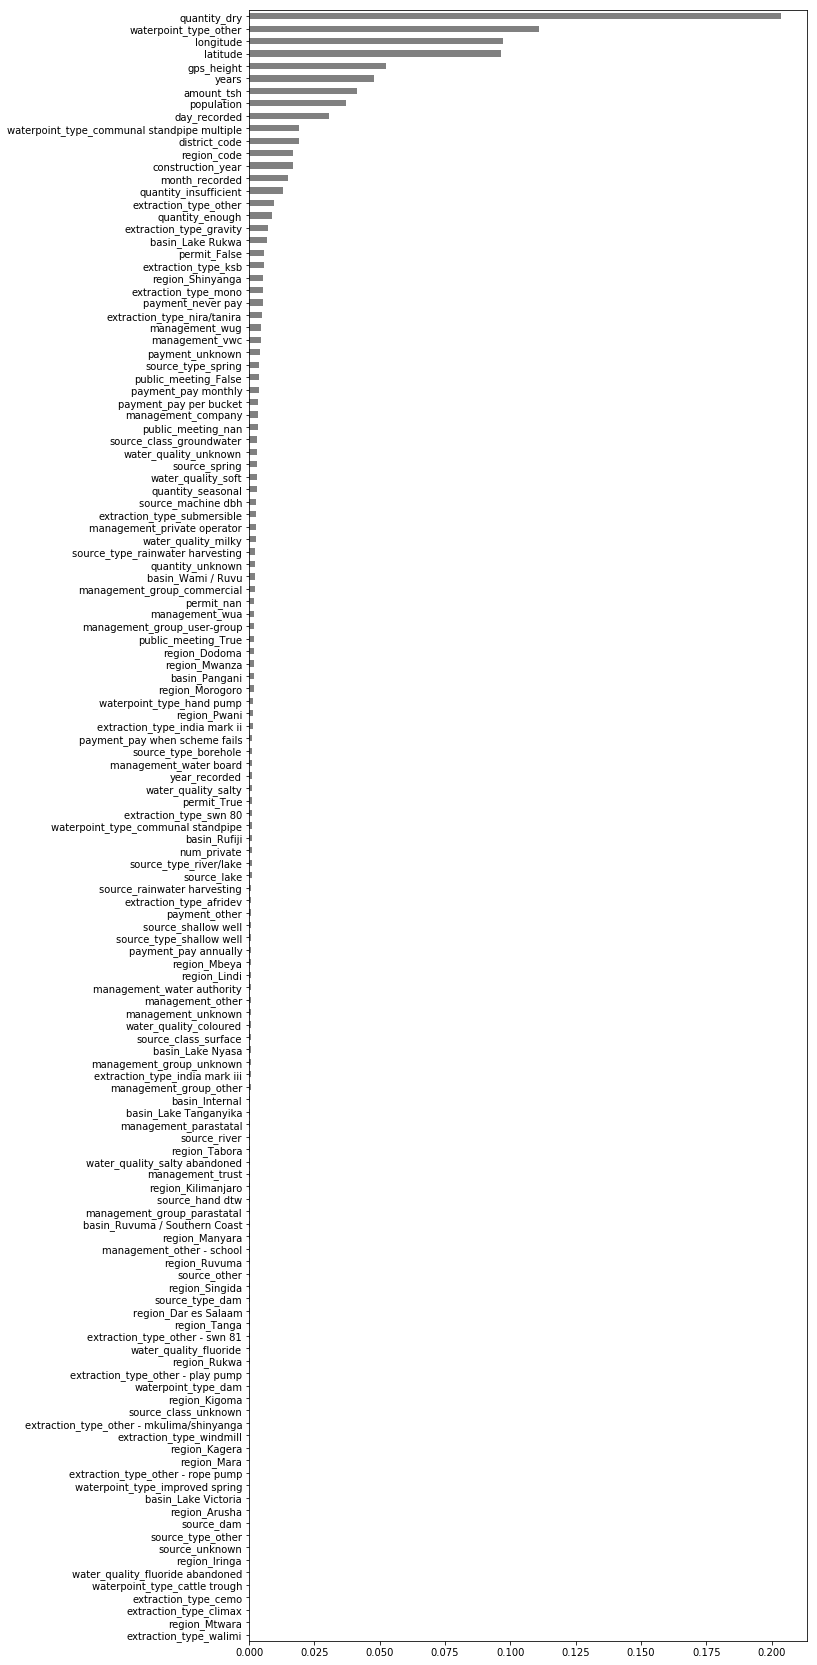

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');